# IFT888 - Question 1 partie 1

* Entra√Æner un r√©seau en utilisant la cross-entropie comme fonction de perte
* Entra√Æner un r√©seau en utilisant l'entropie comme fonction de perte
* Entra√Æner un r√©seau en utilisant l'information comme fonction de perte

Le code de base est tir√© du TP4 du cours IFT603 puis adapt√© pour les besoins de ces d√©monstrations.
Le "blog post" https://mattpetersen.github.io/softmax-with-cross-entropy a √©t√© d'une grande aide pour d√©river le softmax et l'obtenir sous sa forme matricielle.

Premi√®rement, un peu de "poutine" pour charger les librairies et les donn√©es

In [189]:
'''
 Imporation des biblioth√®ques python g√©n√©rales
'''
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.datasets import make_gaussian_quantiles

'''
 Imporation des biblioth√®ques sp√©cifiques au devoir
'''
import utils
from two_layer_classifier import TwoLayerClassifier

%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [190]:
samples_per_class = 250
num_classes = 4

X_, y_ = make_gaussian_quantiles(n_features=2, n_classes=num_classes, n_samples=num_classes * samples_per_class)


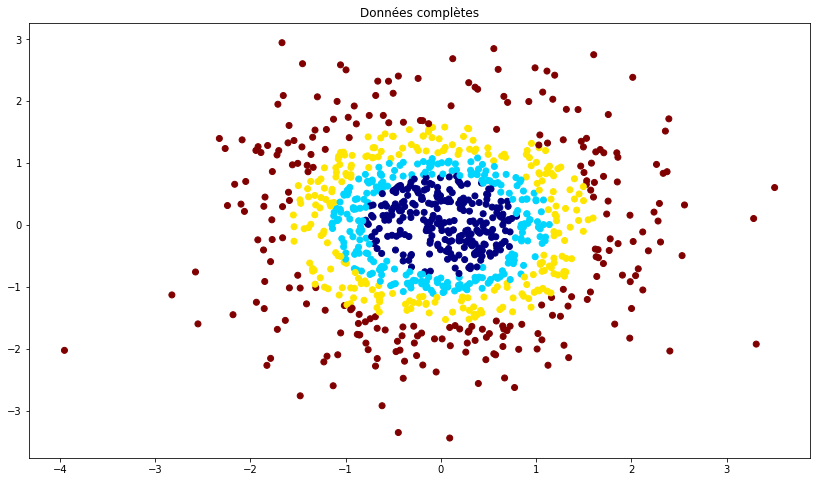

In [191]:
plt.scatter(X_[:, 0], X_[:, 1], c=y_, cmap='jet')
plt.title('Donn√©es compl√®tes')
plt.show()

In [192]:
train_proportion = 0.5
val_proportion = 0.2
num_train = int(len(X_) * train_proportion)
num_val = int(len(X_) * val_proportion)

np.random.seed(0)
idx = np.random.permutation(len(X_))

train_idx = idx[:num_train]
val_idx = idx[num_train:num_train + num_val]
test_idx = idx[num_train + num_val:]

X_train = X_[train_idx]
y_train = y_[train_idx]
X_val = X_[val_idx]
y_val = y_[val_idx]
X_test = X_[test_idx]
y_test = y_[test_idx]

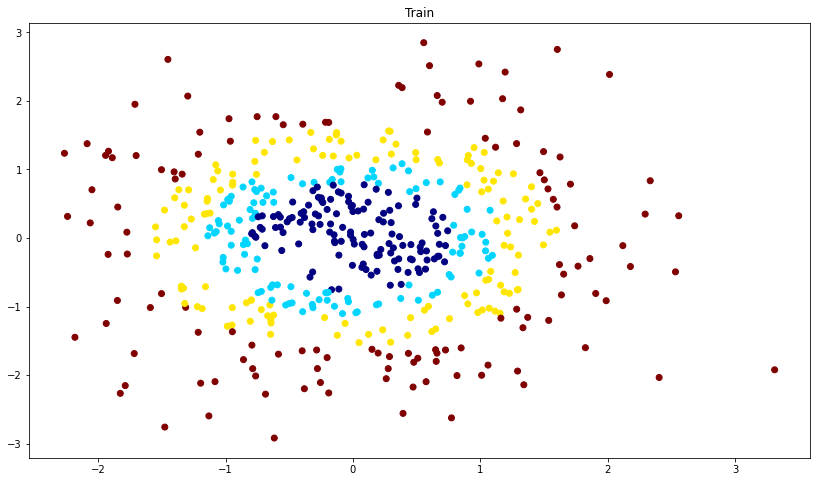

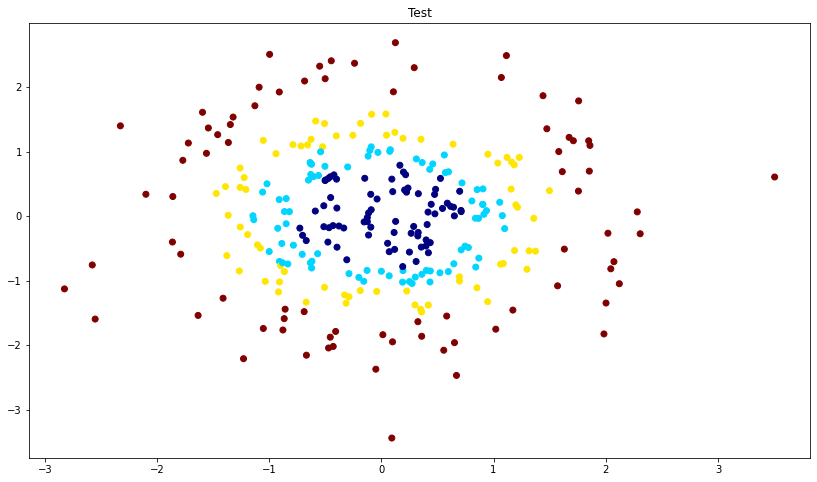

In [193]:
# Affichons maintenant les donn√©es d'entra√Ænement, de validation et de test.
plt.figure()
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='jet')
plt.title('Train')
plt.show()

plt.figure()
plt.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap='jet')
plt.title('Validation')
plt.show()

plt.figure()
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='jet')
plt.title('Test')
plt.show()

# Entra√Æner avec la cross entropie

Commen√ßons d'abord par d√©finir les fonctions de pertes et leurs composantes respectives

La cross-entropy $E_{CE}$ est d√©finie par 

$$E_{CE} = -\sum_c t_c \log y_c(x) = -T \log Y(x)$$

avec $T = (t_0, ..., t_c, ..., t_{C-1})$

Pour mettre √† jour les poids $W$ dans la bonne direction, il est n√©cessaire de d√©river $E_{CE}$ par rapport √† $W$.

$$\frac{\partial E_{CE}}{\partial W} = \frac{\partial E_{CE}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

avec 

$$Y(x) = (y_0(x), ..., y_c(x), ..., y_{C-1}(x)) = (\frac{e^{f(x)_0}}{\sum_{c'} e^{f(x)_{c'}}}, ...,\frac{e^{f(x)_c}}{\sum_{c'} e^{f(x)_{c'}}}, ...,\frac{e^{f(x)_{C-1}}}{\sum_{c'} e^{f(x)_{c'}}})$$

$$f(x)_c = W_c^T x$$

Il faut donc trouver les composantes $\frac{\partial E_{CE}}{\partial Y(x)}$, $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$.


Pour l'erreur, c'est assez simple:

$$\begin{aligned}
    \frac{\partial E_{CE}}{\partial Y(x)} &= \frac{\partial -T \log Y(x)}{\partial Y(x)} \\
                                          &= -\frac{T}{Y(x)}
  \end{aligned}
$$

Pour le softmax, les choses se corsent un peu. Pour des raisons qui deviendront apparentes plus tard, nous devrons obtenir la forme matricielle du jacobien $J_f(Y)$ plut√¥t que la forme par cas telle qu'elle est g√©n√©ralement utilis√©e. En effet, puisque le softmax est une op√©ration $\mathbb{R}^{C-1} \rightarrow \mathbb{R}^{C-1}$, $J_f(Y)$ prend la forme d'une matrice $C-1 \times C-1$ 

$$J_f(Y) = \begin{bmatrix}
J_{i,j} = \frac{\partial y(x)_i}{\partial f(x)_j} 
\end{bmatrix}, i = 0...C-1; j = 0...C-1  $$

La d√©riv√©e partielle devra donc √™tre d√©termin√©e en deux parties: lorsque $i = j$ et lorsque $i \neq j$.

Pour $i = j$:

$$\begin{aligned}
    \frac{\partial y(x)_i}{\partial f(x)_j}  &= \frac{\partial \frac{e^{f(x)_i}}{\sum_{j} e^{f(x)_{cj}}}}{f_j(x)} \\
                                             & = y_i(x) - y_j(x)^2
  \end{aligned}$$
  
Pour $i \neq j$:

$$\begin{aligned}
    \frac{\partial y(x)_i}{\partial f(x)_j}  &= \frac{\partial \frac{e^{f(x)_i}}{\sum_{j} e^{f(x)_{cj}}}}{f_j(x)} \\
                                             & = -y_i(x)y_j(x)
  \end{aligned}$$
  
On obtient donc la matrice

$$ J_f(Y) =
\begin{bmatrix}
y_0(x) - y_0(x)^2 & -y_0(x)y_1(x)     & ...    & -y_0(x)y_{C-1}(x)     \\
-y_1(x)y_0(x)     & y_1(x) - y_1(x)^2 & ...    & -y_1(x)y_{C-1}(x)     \\
\vdots            & ...               & \ddots & \vdots                \\
-y_{C-1}(x)y_0(x) & -y_{C-1}(x)y_1(x) & ...    & -y_{C-1}(x)y_{C-1}(x) \\
\end{bmatrix} = I \cdot Y^T - Y^TY = \frac{\partial Y(x)}{\partial f(x)}.
$$

Finalement,

$$\frac{\partial f(x)}{\partial W} = \frac{\partial W^Tx}{\partial W} = x$$

Ainsi, nous pouvons obtenir la d√©riv√©e de la cross-entropie par rapport aux poids

$$ \frac{\partial E_{CE}}{\partial W} = -\frac{T}{Y(x)} \cdot J_f(Y) \cdot x $$


Maintenant, impl√©mentons ceci et v√©rifions que √ßa fonctionne:

In [194]:
""" Inspired by https://math.stackexchange.com/questions/2843505/derivative-of-softmax-without-cross-entropy # noqa E501
"""

def dloss_chain(d1, d2):
    return np.dot(d1, d2)

def cross_entropy(scores, t):
    return np.sum(-t * np.log(scores + 1e-10))

def cross_entropy_derivative(prob, t):
    return -t/prob

def softmax(scores):
    # For numerical stability. Does not change the prediction.
    scores -= np.max(scores)
    scores_exp = np.exp(scores)
    sum_exp = np.sum(scores_exp)
    class_prob = scores_exp / sum_exp
    return class_prob

def softmax_derivatives(softmax):
    # Jacobian of the softmax.
    # Usually represented using kroenecker delta, the full jacobian allows
    # for chain derivation
    s = softmax.reshape(-1, 1)
    return np.diagflat(s) - np.dot(s, s.T)

def cross_entropy_loss(self, scores, y):
    # y is encoded as a one-hot vector
    t = np.zeros(len(scores))
    t[y] = 1.

    probs = softmax(scores)
    loss = cross_entropy(probs, t)

    # "Analytical derivation
    dloss_dscores_analytical = probs - t

    # Chain derivation
    # ‚àíùëáùëå(ùë•)
    dcross_dsoft = cross_entropy_derivative(probs, t)
    # ùêΩùëì(ùëå)
    dsoft_dscores = softmax_derivatives(probs)
    # ‚àíùëáùëå(ùë•)‚ãÖùêΩùëì(ùëå)
    dloss_dscores = dloss_chain(
        dcross_dsoft, dsoft_dscores)

    # Test to make sure chain derivation works
    assert np.allclose(dloss_dscores, dloss_dscores_analytical)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores

Commen√ßons avec quelques **Sanity checks** pour s'assurer que l'entra√Ænement avec la cross-entropy fonctionne correctement

In [195]:
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, cross_entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# V√©rifier que la sortie du r√©seau initialis√© au hasard donne bien une pr√©diction √©gale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, cross_entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des donn√©es d'entra√Ænement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au r√©sultat attendu
loss_attendu = -np.log(1.0/num_classes) # r√©sultat al√©atoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))
if abs(loss - loss_attendu) > 0.05:
    print('ERREUR: la sortie de la fonction est incorrecte.')
else:
    print('SUCC√àS')

Sortie: 1.3932263102828293  Attendu: 1.3862943611198906
SUCC√àS


In [196]:
# V√©rifier que le fait d'augmenter la r√©gularisation L2 augmente √©galement la loss
for l2_r in np.arange(0,2,0.1):
    _, loss = model.global_accuracy_and_loss(X_train,y_train, l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entra√Ænement : {:.3f}'.format(l2_r,loss))

l2_reg= 0.0000 >> Loss/accuracy d'entra√Ænement : 1.393
l2_reg= 0.1000 >> Loss/accuracy d'entra√Ænement : 1.419
l2_reg= 0.2000 >> Loss/accuracy d'entra√Ænement : 1.444
l2_reg= 0.3000 >> Loss/accuracy d'entra√Ænement : 1.469
l2_reg= 0.4000 >> Loss/accuracy d'entra√Ænement : 1.495
l2_reg= 0.5000 >> Loss/accuracy d'entra√Ænement : 1.520
l2_reg= 0.6000 >> Loss/accuracy d'entra√Ænement : 1.546
l2_reg= 0.7000 >> Loss/accuracy d'entra√Ænement : 1.571
l2_reg= 0.8000 >> Loss/accuracy d'entra√Ænement : 1.597
l2_reg= 0.9000 >> Loss/accuracy d'entra√Ænement : 1.622
l2_reg= 1.0000 >> Loss/accuracy d'entra√Ænement : 1.647
l2_reg= 1.1000 >> Loss/accuracy d'entra√Ænement : 1.673
l2_reg= 1.2000 >> Loss/accuracy d'entra√Ænement : 1.698
l2_reg= 1.3000 >> Loss/accuracy d'entra√Ænement : 1.724
l2_reg= 1.4000 >> Loss/accuracy d'entra√Ænement : 1.749
l2_reg= 1.5000 >> Loss/accuracy d'entra√Ænement : 1.775
l2_reg= 1.6000 >> Loss/accuracy d'entra√Ænement : 1.800
l2_reg= 1.7000 >> Loss/accuracy d'entra√Ænement 

In [197]:
# V√©rification: Vous devez pouvoir faire du surapprentissage sur quelques √©chantillons.
# Si l'accuracy reste faible, votre impl√©mentation a un bogue.
n_check = 5
X_check = X_train[:n_check]
y_check = y_train[:n_check]
model = TwoLayerClassifier( X_check, y_check, X_val, y_val, cross_entropy_loss,
    num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes
)

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=100, lr=0.1, l2_reg=0.0)
print('Accuracy d\'entra√Ænement, devrait √™tre 1.0: {:.3f}'.format(accu_train_curve[-1]))
if accu_train_curve[-1] < 0.98:
    print('ATTENTION: L\'accuracy n\'est pas 100%.')
    utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve)
else:
    print('SUCC√àS')

Accuracy d'entra√Ænement, devrait √™tre 1.0: 1.000
SUCC√àS


In [198]:
# V√©rifier que le fait d'entra√Æner avec une r√©gularisation L2 croissante augmente la loss et, √©ventuellement, diminue l'accuracy
for l2_r in np.arange(0,1,0.1):
    loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=0.01, l2_reg=l2_r)
    print('l2_reg= {:.4f} >> Loss/accuracy d\'entra√Ænement : {:.3f} {:.3f}'.format(l2_r,loss_train_curve[-1],accu_train_curve[-1]))


l2_reg= 0.0000 >> Loss/accuracy d'entra√Ænement : 0.706 0.800
l2_reg= 0.1000 >> Loss/accuracy d'entra√Ænement : 1.167 0.600
l2_reg= 0.2000 >> Loss/accuracy d'entra√Ænement : 1.238 0.400
l2_reg= 0.3000 >> Loss/accuracy d'entra√Ænement : 1.283 0.600
l2_reg= 0.4000 >> Loss/accuracy d'entra√Ænement : 1.301 0.600
l2_reg= 0.5000 >> Loss/accuracy d'entra√Ænement : 1.312 0.400
l2_reg= 0.6000 >> Loss/accuracy d'entra√Ænement : 1.321 0.400
l2_reg= 0.7000 >> Loss/accuracy d'entra√Ænement : 1.328 0.400
l2_reg= 0.8000 >> Loss/accuracy d'entra√Ænement : 1.334 0.400
l2_reg= 0.9000 >> Loss/accuracy d'entra√Ænement : 1.338 0.400


Maintenant, entra√Ænons pour de vrai:

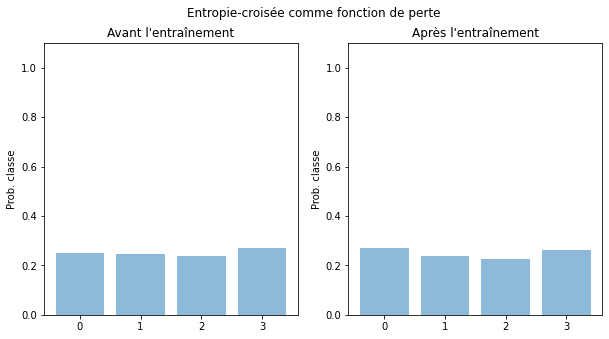

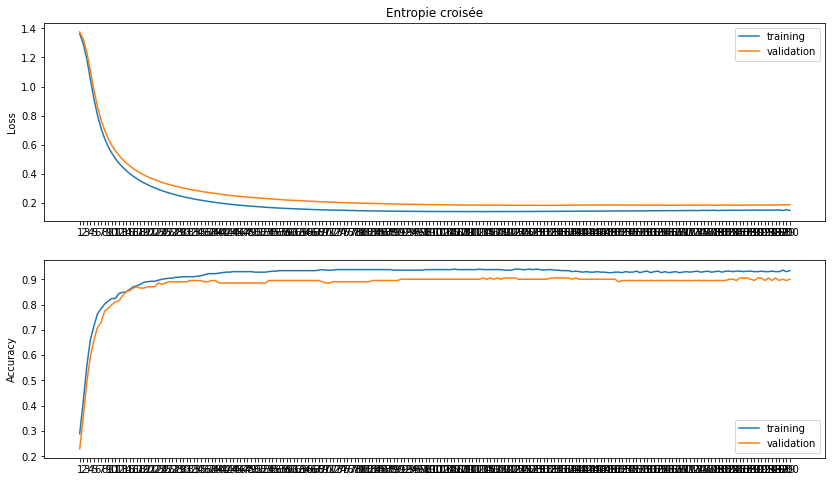

[Training]   Loss: 0.150   Accuracy: 0.934
[Validation] Loss: 0.190   Accuracy: 0.900


In [199]:
# On instancie notre mod√®le; cette fois-ci avec les donn√©es compl√®tes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  cross_entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les donn√©es de test AVANT l'entra√Ænement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Entropie-crois√©e comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entra√Ænement')

# On entra√Æne

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)


# On calcule la prob moyenne pour chaque classe selon les donn√©es de test APR√àS l'entra√Ænement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Apr√®s l\'entra√Ænement')

# Illustration de la loss et de l'accuracy (le % de biens class√©s) √† chaque it√©ration     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie crois√©e")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

In [200]:
# Visualisation des r√©sultats

h = 0.05  # contr√¥le la r√©solution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Cr√©er la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les pr√©dictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les donn√©es

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Fronti√®res de d√©cision en utilisant l\'entropie-crois√©e')
plt.show()

# Entra√Ænement avec l'entropie


L'entropie $E_{E}$ est d√©finie par 

$$E_{E} = -\sum_c y_c(x) \log y_c(x) = -Y \log Y(x)$$


Pour mettre √† jour les poids $W$ dans la bonne direction, il est n√©cessaire de d√©river $E_{E}$ par rapport √† $W$.

$$\frac{\partial E_{E}}{\partial W} = \frac{\partial E_{E}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

Puisque nous avons d√©j√† $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$, il ne nous reste qu'√† trouver $\frac{\partial E_{E}}{\partial Y(x)}$:

$$\begin{aligned}
    \frac{\partial E_{E}}{\partial Y(x)} &= \frac{\partial -Y(x) \log Y(x)}{\partial Y(x)} \\
                                         &= \frac{\partial -Y(x)}{\partial Y(x)} \log Y(x) + Y(x) + \frac{\partial \log Y(x)}{\partial Y(x)} \\
                                         &= -\log Y(x) + Y(x) \frac{1}{Y(x)} \\
                                         &= -\log Y(x) + 1
  \end{aligned}
$$




Ainsi, nous pouvons obtenir la d√©riv√©e de l'entropie e par rapport aux poids

$$ \frac{\partial E_{E}}{\partial W} = -\log Y(x) + 1 \cdot J_f(Y) \cdot x $$


Maintenant, impl√©mentons ceci et v√©rifions que √ßa fonctionne: Alors que la cross-entropie agit comme une fonction d'erreur typique, l'entropie ne devrait pas avoir d'impact particulier sur l'accuracy, ou en tout cas ne devrait pas l'augmenter. Plut√¥t, l'entropie de la sortie softmax devrait diminuer progressivement durant l'entra√Ænement. Voyons voir.

In [201]:
# Tout d'abord, quelques fonctions.

def entropy(scores, t):
    # Does not use 't'
    return np.sum(-scores * np.log(scores + 1e-10))

def entropy_derivative(scores, t):
    return -np.log(scores + 1e-10) + 1
    
def entropy_loss(self, scores, y):
    t = np.zeros(len(scores))
    t[y] = 1.

    class_prob = softmax(scores)
    loss = entropy(class_prob, t)

    dent_dsoft = entropy_derivative(class_prob, t)
    dsoft_dscores = softmax_derivatives(class_prob)
    dloss_dscores = dloss_chain(
        dent_dsoft, dsoft_dscores)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores


In [202]:
# V√©rifier que la sortie du r√©seau initialis√© au hasard donne bien une pr√©diction √©gale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, entropy_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des donn√©es d'entra√Ænement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au r√©sultat attendu
scores_equal = np.array([1/num_classes] * num_classes)
loss_attendu = entropy(scores_equal, None) # r√©sultat al√©atoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))

Sortie: 1.3803616699541668  Attendu: 1.3862943607198905


In [203]:
# On instancie notre mod√®le avec les donn√©es compl√®tes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens class√©s) √† chaque it√©ration     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

[Training]   Loss: 0.000   Accuracy: 0.256
[Validation] Loss: 0.000   Accuracy: 0.220


On peut s'appercevoir que la loss d√©croit, et que l'entropie du softmax coverge vers z√©ro. Comment visualiser l'effet de cet entra√Ænement ? Une fa√ßon serait de visualiser la probabilit√© de chaque classe en moyenne avant et apr√®s l'entra√Ænement. Alors que la probabilit√© devrait √™tre √©gale partout avant, la probabilit√© devrait √™tre autour de 1 pour une, et z√©ro pour le reste. Voyons voir.  

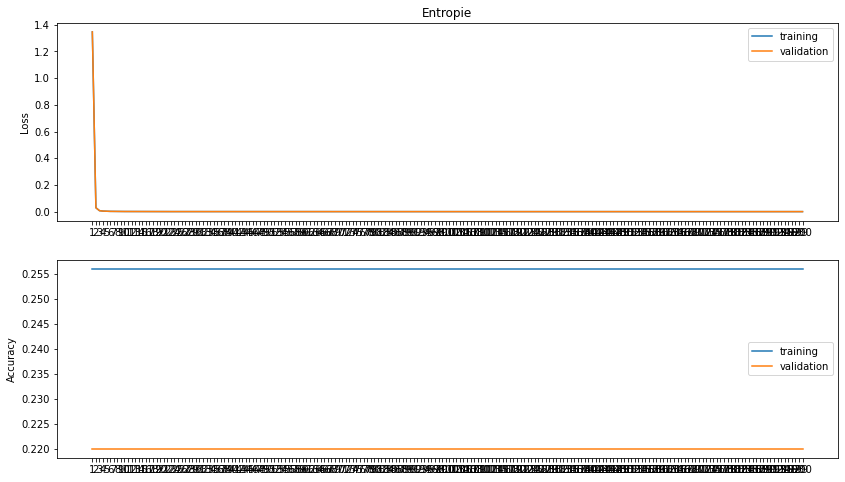

[Training]   Loss: 0.000   Accuracy: 0.256
[Validation] Loss: 0.000   Accuracy: 0.220


In [204]:
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  entropy_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les donn√©es de test AVANT l'entra√Ænement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Entropie comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entra√Ænement')

# On entra√Æne
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# On calcule la prob moyenne pour chaque classe selon les donn√©es de test APR√àS l'entra√Ænement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Apr√®s l\'entra√Ænement')

# Illustration de la loss et de l'accuracy (le % de biens class√©s) √† chaque it√©ration     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Entropie")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

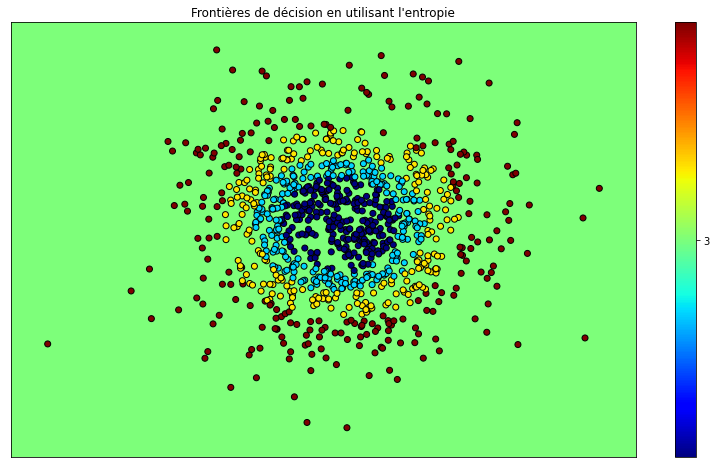

In [205]:
# Visualisation des r√©sultats

h = 0.05  # contr√¥le la r√©solution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Cr√©er la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les pr√©dictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les donn√©es

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Fronti√®res de d√©cision en utilisant l\'entropie')
plt.show()

# Entra√Ænement avec l'information

La fonction de co√ªt d'information $E_{I}$ est d√©finie par 

$$E_{I} = -\sum_c \log y_c(x) = -\log Y(x)$$

Pour mettre √† jour les poids $W$ dans la bonne direction, il est n√©cessaire de d√©river $E_{I}$ par rapport √† $W$.

$$\frac{\partial E_{I}}{\partial W} = \frac{\partial E_{I}}{\partial Y(x)}\frac{\partial Y(x)}{\partial f(x)}\frac{\partial f(x)}{\partial W},$$

Puisque nous avons d√©j√† $\frac{\partial Y(x)}{\partial f(x)}$ et $\frac{\partial f(x)}{\partial W}$, il ne nous reste qu'√† trouver $\frac{\partial E_{I}}{\partial Y(x)}$:

$$\begin{aligned}
    \frac{\partial E_{I}}{\partial Y(x)} &= \frac{\partial -\log Y(x)}{\partial Y(x)} \\
                                         &= -\frac{1}{Y(x)}
  \end{aligned}
$$

Ainsi, nous pouvons obtenir la d√©riv√©e de l'information par rapport aux poids

$$ \frac{\partial E_{E}}{\partial W} = -\frac{1}{Y(x)} \cdot J_f(Y) \cdot x $$


Maintenant, impl√©mentons ceci et v√©rifions que √ßa fonctionne: Alors que la cross-entropie agit comme une fonction d'erreur typique, et que l'entropie force une classe √† √™tre pr√©dite tout le temps, l'information ne devrait pas varier grandement durant l'entra√Ænement. En effet, un r√©seau non-entra√Æn√© pr√©dit d√©j√† une probabilit√© plus-ou-moins √©gale pour chaque classe. Minimiser l'information en sortie du softmax devrait forcer le r√©seau √† pr√©dire √©galement toutes les classes, maximisant l'entropie.

In [206]:
# Tout d'abord, quelques fonctions.

def information(scores, t):
    # Does not use 't'
    return -np.sum(np.log(scores + 1e-10))

def information_derivative(scores, t):
    return -1/(scores + 1e-10)
    
def information_loss(self, scores, y):
    t = np.zeros(len(scores))
    t[y] = 1.

    class_prob = softmax(scores)
    loss = information(class_prob, t)

    dinf_dsoft = information_derivative(class_prob, t)
    dsoft_dscores = softmax_derivatives(class_prob)
    dloss_dscores = dloss_chain(
        dinf_dsoft, dsoft_dscores)

    # Regularization cost
    for w in zip(self.parameters):
        loss += 0.5 * self.l2_reg * np.sum(np.square(w))

    return loss, dloss_dscores


In [207]:
# V√©rifier que la sortie du r√©seau initialis√© au hasard donne bien une pr√©diction √©gale pour chaque classe
num_hidden_neurons = 10
model = TwoLayerClassifier(X_train, y_train, X_val, y_val, information_loss,
                           num_features=2, num_hidden_neurons=num_hidden_neurons, num_classes=num_classes)

# 2. Appeler la fonction qui calcule l'accuracy et la loss moyenne pour l'ensemble des donn√©es d'entra√Ænement
_, loss = model.global_accuracy_and_loss(X_train,y_train,0)

# 3. Comparer au r√©sultat attendu
scores_equal = np.array([1/num_classes] * num_classes)
loss_attendu = information(scores_equal, None) # r√©sultat al√©atoire attendu soit -log(1/nb_classes)
print('Sortie: {}  Attendu: {}'.format(loss, loss_attendu))

Sortie: 5.556072611467796  Attendu: 5.545177442879562


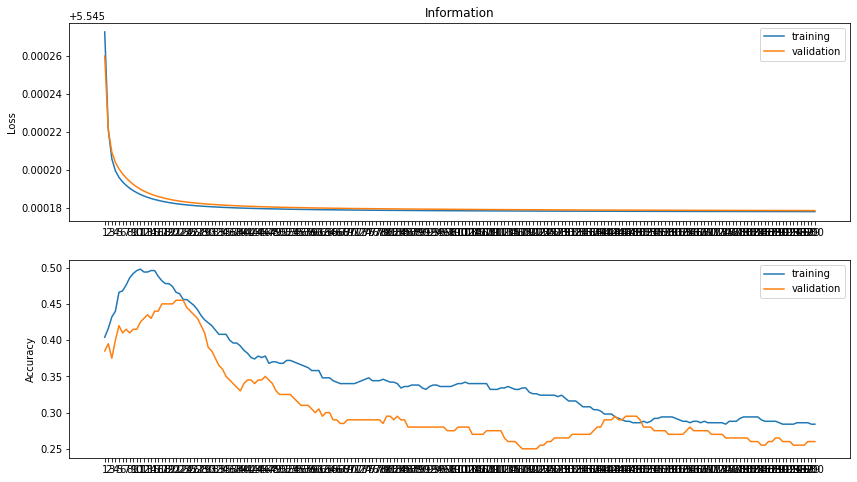

[Training]   Loss: 5.545   Accuracy: 0.284
[Validation] Loss: 5.545   Accuracy: 0.260


In [208]:
# On instancie notre mod√®le avec les donn√©es compl√®tes.
num_hidden_neurons = 20
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  information_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# Illustration de la loss et de l'accuracy (le % de biens class√©s) √† chaque it√©ration     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Information")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

On peut voir que la loss d√©croit l√©g√®rement (voir l'√©chelle), et que la somme de l'information du softmax coverge vers une valeur. Comment visualiser l'effet de cet entra√Ænement ? Une fa√ßon serait de visualiser la probabilit√© de chaque classe en moyenne avant et apr√®s l'entra√Ænement. En minimisant l'information, l'entropie devrait devenir √©gale pour chaque classe. Voyons voir.  

In [209]:
model = TwoLayerClassifier(X_train, y_train, X_val, y_val,  information_loss, num_features=2,
                           num_hidden_neurons=num_hidden_neurons, num_classes=num_classes, activation='relu')

# On calcule la prob moyenne pour chaque classe selon les donn√©es de test AVANT l'entra√Ænement
before_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

y_pos = np.arange(num_classes)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle("Information comme fonction de perte")

axes[0].bar(y_pos, before_train_test_scores, align='center', alpha=0.5)
axes[0].set_ylabel('Prob. classe')
axes[0].set_ylim(0, 1.1)
axes[0].set_title('Avant l\'entra√Ænement')

# On entra√Æne
loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve = model.train(num_epochs=200, lr=1e-2, l2_reg=0.0,
                                                                                 momentum=0.5)

# On calcule la prob moyenne pour chaque classe selon les donn√©es de test APR√àS l'entra√Ænement
after_train_test_scores = np.array([softmax(model.net.forward(x)) for x in X_test]).mean(axis=0)  # Classifier chaque point de la grille

axes[1].bar(y_pos, after_train_test_scores, align='center', alpha=0.5)
axes[1].set_ylabel('Prob. classe')
axes[1].set_ylim(0, 1.1)
axes[1].set_title('Apr√®s l\'entra√Ænement')

# Illustration de la loss et de l'accuracy (le % de biens class√©s) √† chaque it√©ration     
utils.plot_curves(loss_train_curve, loss_val_curve, accu_train_curve, accu_val_curve, title="Information")

print('[Training]   Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_train_curve[-1], accu_train_curve[-1]))
print('[Validation] Loss: {:.3f}   Accuracy: {:.3f}'.format(loss_val_curve[-1], accu_val_curve[-1]))

plt.show()

[Training]   Loss: 5.545   Accuracy: 0.290
[Validation] Loss: 5.545   Accuracy: 0.210


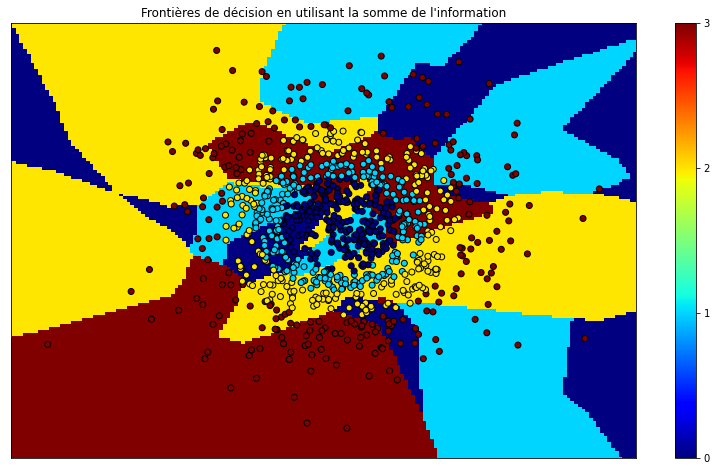

In [210]:
# Visualisation des r√©sultats

h = 0.05  # contr√¥le la r√©solution de la grille
x_min, x_max = X_[:, 0].min() - .5, X_[:, 0].max() + .5  # Limites de la grille
y_min, y_max = X_[:, 1].min() - .5, X_[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))  # Cr√©er la grille

X_predict = np.c_[xx.ravel(), yy.ravel()]  # Convertir la grille en une liste de points
Z = model.predict(X_predict)  # Classifier chaque point de la grille
Z = Z.reshape(xx.shape)  # Remettre en 2D

plt.figure(figsize=(14, 8))
im = plt.pcolormesh(xx, yy, Z, cmap='jet', shading='nearest')  # Colorier les cases selon les pr√©dictions
plt.colorbar(im, ticks=[0, 1, 2, 3])

X_plot, y_plot = X_, y_
plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y_plot, edgecolors='k', cmap='jet')  # Tracer les donn√©es

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.title('Fronti√®res de d√©cision en utilisant la somme de l\'information')
plt.show()